# PREPROCESSING

In [2]:
import os
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt, savgol_filter

# === Step 1: Configuration ===
folder_path = "Data"
fs = 100  

# === Step 2: Define Filters ===

# Bandpass Butterworth filter (0.5–8 Hz is typical for PPG)
def butter_bandpass_filter(signal, lowcut=0.5, highcut=8, fs=100, order=4):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

# Normalization
def normalize_signal(signal):
    return (signal - np.min(signal)) / (np.max(signal) - np.min(signal))

# === Step 3: Process Files ===
csv_files = [f for f in os.listdir(folder_path) if f.endswith('.csv')]

for file in csv_files:
    file_path = os.path.join(folder_path, file)
    df = pd.read_csv(file_path)

    if 'ABP' in df.columns:
        df = df.drop(columns=['ABP'])

    if 'PPG' not in df.columns:
        print(f"⚠️ PPG column not found in: {file}")
        continue

    # Get original PPG signal
    ppg_raw = df['PPG'].values

    # === Step 4: Apply Filters ===
    ppg_filtered = butter_bandpass_filter(ppg_raw, fs=fs)
    ppg_smooth = savgol_filter(ppg_filtered, window_length=51, polyorder=3)
    ppg_norm = normalize_signal(ppg_smooth)

    # Replace PPG in DataFrame
    df['PPG'] = ppg_norm

    # Save cleaned CSV
    df.to_csv(file_path, index=False)
    print(f"✅ Preprocessed and saved: {file}")


✅ Preprocessed and saved: 001.csv
✅ Preprocessed and saved: 002.csv
✅ Preprocessed and saved: 003.csv
✅ Preprocessed and saved: 004.csv
✅ Preprocessed and saved: 005.csv
✅ Preprocessed and saved: 006.csv
✅ Preprocessed and saved: 007.csv
✅ Preprocessed and saved: 008.csv
✅ Preprocessed and saved: 009.csv
✅ Preprocessed and saved: 010.csv
✅ Preprocessed and saved: 011.csv
✅ Preprocessed and saved: 012.csv
✅ Preprocessed and saved: 013.csv
✅ Preprocessed and saved: 014.csv
✅ Preprocessed and saved: 015.csv
✅ Preprocessed and saved: 016.csv
✅ Preprocessed and saved: 017.csv
✅ Preprocessed and saved: 018.csv
✅ Preprocessed and saved: 019.csv
✅ Preprocessed and saved: 020.csv
✅ Preprocessed and saved: 021.csv
✅ Preprocessed and saved: 022.csv
✅ Preprocessed and saved: 023.csv
✅ Preprocessed and saved: 024.csv
✅ Preprocessed and saved: 025.csv
✅ Preprocessed and saved: 026.csv
✅ Preprocessed and saved: 027.csv
✅ Preprocessed and saved: 028.csv
✅ Preprocessed and saved: 029.csv


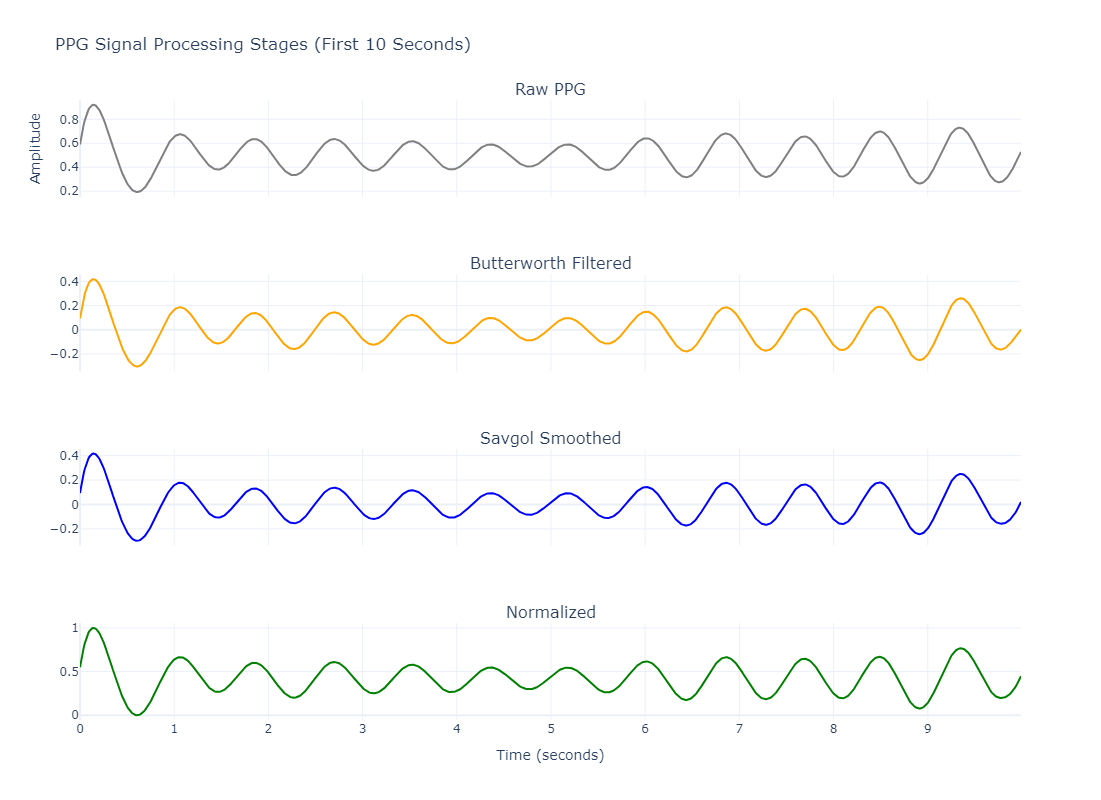

In [3]:
import pandas as pd
import numpy as np
from scipy.signal import butter, filtfilt, savgol_filter
import plotly.graph_objs as go
from plotly.subplots import make_subplots

# === Configuration ===
file_path = "Data/001.csv"  # <-- Update this
fs = 100  # Hz
duration_sec = 10
samples = fs * duration_sec


# === Load and Slice Data ===
df = pd.read_csv(file_path)
ppg_raw = df['PPG'].values[:samples]

# === Apply Filters ===
ppg_band = butter_bandpass_filter(ppg_raw, fs=fs)
ppg_smooth = savgol_filter(ppg_band, window_length=51, polyorder=3)
ppg_norm = normalize_signal(ppg_smooth)

# === Time Axis ===
time = np.arange(samples) / fs

# === Create 4 Subplots ===
fig = make_subplots(rows=4, cols=1, shared_xaxes=True,
                    subplot_titles=["Raw PPG", "Butterworth Filtered", "Savgol Smoothed", "Normalized"])

fig.add_trace(go.Scatter(x=time, y=ppg_raw, mode='lines', name="Raw PPG", line=dict(color='gray')), row=1, col=1)
fig.add_trace(go.Scatter(x=time, y=ppg_band, mode='lines', name="Butterworth", line=dict(color='orange')), row=2, col=1)
fig.add_trace(go.Scatter(x=time, y=ppg_smooth, mode='lines', name="Savgol", line=dict(color='blue')), row=3, col=1)
fig.add_trace(go.Scatter(x=time, y=ppg_norm, mode='lines', name="Normalized", line=dict(color='green')), row=4, col=1)

# === Layout ===
fig.update_layout(
    height=800,
    title="PPG Signal Processing Stages (First 10 Seconds)",
    xaxis4_title="Time (seconds)",
    yaxis_title="Amplitude",
    showlegend=False,
    template="plotly_white"
)

fig.show()


In [4]:
import os
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.signal import find_peaks, butter, filtfilt, savgol_filter

fs = 100
segment_len = 1000  # 10 seconds

def bandpass_filter(signal, fs, lowcut=0.5, highcut=8, order=2):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

def savgol_filtered(signal):
    return savgol_filter(signal, window_length=101, polyorder=3)

def compute_hr_hrv(peaks, fs):
    rr_intervals = np.diff(peaks) / fs
    if len(rr_intervals) < 2:
        return -1, -1
    hr = 60 / np.mean(rr_intervals)
    hrv = np.std(rr_intervals)
    return hr, hrv

def get_hypertension_label(sbp, dbp):
    if sbp < 120 and dbp < 80:
        return "normal"
    elif 120 <= sbp < 140 or 80 <= dbp < 90:
        return "prehypertension"
    else:
        return "hypertension"

def extract_features_from_segment(segment, fs):
    filtered = bandpass_filter(segment, fs)
    filtered = savgol_filtered(filtered)

    peaks, _ = find_peaks(filtered, distance=fs*0.5)
    hr, hrv = compute_hr_hrv(peaks, fs)

    fft_vals = np.abs(np.fft.rfft(filtered))
    fft_freqs = np.fft.rfftfreq(len(filtered), 1/fs)
    dom_freq = fft_freqs[np.argmax(fft_vals)]

    return {
        "mean": np.mean(filtered),
        "std": np.std(filtered),
        "kurtosis": kurtosis(filtered),
        "skewness": skew(filtered),
        "peak_count": len(peaks),
        "hr": hr,
        "hrv": hrv,
        "dom_freq": dom_freq
    }

def process_file(filepath):
    df = pd.read_csv(filepath)
    subject_id = os.path.basename(filepath).split('.')[0]
    
    ppg = df['PPG'].values
    sbp = np.mean(df['SBP'].values)
    dbp = np.mean(df['DBP'].values)
    label = get_hypertension_label(sbp, dbp)

    segments = len(ppg) // segment_len
    features = []

    for i in range(segments):
        start = i * segment_len
        end = start + segment_len
        segment = ppg[start:end]
        if len(segment) < segment_len:
            continue

        feat = extract_features_from_segment(segment, fs)
        feat["subject_id"] = subject_id
        feat["segment"] = i
        feat["label"] = label
        features.append(feat)

    return features


In [5]:
data_dir = "Data"
all_features = []

for file in os.listdir(data_dir):
    if file.endswith(".csv"):
        try:
            filepath = os.path.join(data_dir, file)
            feats = process_file(filepath)
            all_features.extend(feats)
        except Exception as e:
            print(f"❌ Error processing {file}: {e}")

df = pd.DataFrame(all_features)
df.to_csv("segmented_features.csv", index=False)
print("✅ Extracted segmented features:", df.shape)


✅ Extracted segmented features: (16402, 11)


# FEATURE EXTRACTION

In [14]:
import os
import pandas as pd
import numpy as np
from scipy.stats import skew, kurtosis
from scipy.signal import find_peaks
from scipy.signal import butter, filtfilt, savgol_filter

# === SETTINGS ===
data_dir = "Data"  # Change this to your folder path
fs = 100  # Sampling frequency
duration_sec = 10
samples = fs * duration_sec

# === Filter Functions ===
def bandpass_filter(signal, fs, lowcut=0.5, highcut=8, order=2):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, signal)

def savgol_filtered(signal):
    return savgol_filter(signal, window_length=101, polyorder=3)

# === HR/HRV Extraction ===
def compute_hr_hrv(peaks, fs):
    rr_intervals = np.diff(peaks) / fs
    if len(rr_intervals) < 2:
        return -1, -1
    hr = 60 / np.mean(rr_intervals)
    hrv = np.std(rr_intervals)
    return hr, hrv

# === Feature Extraction per file ===
def extract_features(filepath):
    df = pd.read_csv(filepath)
    subject_id = os.path.basename(filepath).split('.')[0]

    ppg = df['PPG'].values[:samples]
    sbp = df['SBP'].values[:samples]
    dbp = df['DBP'].values[:samples]

    # Filter
    filtered = bandpass_filter(ppg, fs)
    filtered = savgol_filtered(filtered)

    # Peaks
    peaks, _ = find_peaks(filtered, distance=fs*0.5)import numpy as np
from scipy.signal import find_peaks

# === Step 1: Load PPG signal ===
signal = np.loadtxt('your_ppg_file.txt')  # replace with your path
fs = 100  # Sampling frequency in Hz (adjust if different)

# === Step 2: Peak Detection ===
peaks, _ = find_peaks(signal, distance=fs*0.6)  # assume min heart rate = 100 BPM => 0.6s distance

# === Step 3: RR Intervals Calculation ===
rr_intervals = np.diff(peaks) / fs  # Convert from sample index difference to seconds

# === Step 4: Safety Check & HR, HRV Calculation ===
if len(rr_intervals) > 1 and np.all(rr_intervals > 0):
    mean_rr = np.mean(rr_intervals)
    hr = 60 / mean_rr
    hrv = np.std(rr_intervals)
else:
    hr = 0
    hrv = 0

# === Output ===
print(f"Heart Rate (HR): {hr:.2f} BPM")
print(f"Heart Rate Variability (HRV): {hrv:.4f} seconds")

    hr, hrv = compute_hr_hrv(peaks, fs)

    # RR Intervals
    rr_intervals = np.diff(peaks) / fs
    mean_rr = np.mean(rr_intervals) if len(rr_intervals) > 0 else -1
    median_rr = np.median(rr_intervals) if len(rr_intervals) > 0 else -1
    min_rr = np.min(rr_intervals) if len(rr_intervals) > 0 else -1
    max_rr = np.max(rr_intervals) if len(rr_intervals) > 0 else -1

    # Morphological
    max_val = np.max(filtered)
    min_val = np.min(filtered)
    range_val = max_val - min_val
    skewness = skew(filtered)

    # Pulse Width at Half Max (rough estimate)
    half_max = (max_val + min_val) / 2
    half_max_indices = np.where(filtered > half_max)[0]
    pulse_width = (half_max_indices[-1] - half_max_indices[0]) / fs if len(half_max_indices) > 1 else -1

    # FFT for dominant frequency
    fft_vals = np.abs(np.fft.rfft(filtered))
    fft_freqs = np.fft.rfftfreq(len(filtered), 1/fs)
    dom_freq = fft_freqs[np.argmax(fft_vals)]

    # SBP/DBP-based
    mean_sbp = np.mean(sbp)
    mean_dbp = np.mean(dbp)
    pp = mean_sbp - mean_dbp
    map_val = mean_dbp + (pp / 3)

    return {
        "subject_id": subject_id,
        "mean": np.mean(filtered),
        "std": np.std(filtered),
        "kurtosis": kurtosis(filtered),
        "skewness": skewness,
        "range": range_val,
        "max_val": max_val,
        "min_val": min_val,
        "pulse_width_half_max": pulse_width,

        "peak_count": len(peaks),
        "mean_hr": hr,
        "hr_variability": hrv,
        "mean_rr": mean_rr,
        "median_rr": median_rr,
        "min_rr": min_rr,
        "max_rr": max_rr,

        "dominant_freq": dom_freq,

        "SBP": mean_sbp,
        "DBP": mean_dbp,
        "PP": pp,
        "MAP": map_val
    }


# === Loop through all CSV files ===
features = []
for file in os.listdir(data_dir):
    if file.endswith(".csv"):
        try:
            filepath = os.path.join(data_dir, file)
            feat = extract_features(filepath)
            features.append(feat)
        except Exception as e:
            print(f"❌ Error processing {file}: {e}")

# === Save to CSV ===
features_df = pd.DataFrame(features)
features_df.to_csv("features_extracted.csv", index=False)
print("✅ Saved features_extracted.csv with shape:", features_df.shape)


✅ Saved features_extracted.csv with shape: (29, 21)


In [15]:
def classify_bp(sbp, dbp):
    if sbp < 120 and dbp < 80:
        return 0  # Normal
    elif 120 <= sbp < 130 and dbp < 80:
        return 1  # Prehypertension
    elif 130 <= sbp < 140 or 80 <= dbp < 90:
        return 2  # Stage 1 Hypertension
    else:
        return 3  # Stage 2 Hypertension


In [24]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
import plotly.graph_objs as go

# Load raw PPG signal from original .txt or .csv
ppg_signal = np.loadtxt('path_to_raw_ppg_file.txt')  # replace with actual path

# Normalize
ppg_norm = (ppg_signal - np.min(ppg_signal)) / (np.max(ppg_signal) - np.min(ppg_signal))

# Detect peaks
fs = 100  # or whatever your sampling rate is
peaks, _ = find_peaks(ppg_norm, distance=fs*0.6)

# Plot
time = np.arange(len(ppg_signal)) / fs
fig = go.Figure()
fig.add_trace(go.Scatter(x=time, y=ppg_norm, mode='lines', name='PPG Signal'))
fig.add_trace(go.Scatter(x=peaks/fs, y=ppg_norm[peaks], mode='markers', name='Peaks', marker=dict(color='red')))
fig.update_layout(title='PPG Signal with Peaks', xaxis_title='Time (s)', yaxis_title='Amplitude')
fig.show()


KeyError: 'PPG'

In [23]:
import plotly.graph_objs as go

time = np.arange(len(ppg_norm)) / fs
fig = go.Figure()
fig.add_trace(go.Scatter(x=time, y=ppg_norm, mode='lines', name='PPG Signal'))
fig.add_trace(go.Scatter(x=peaks/fs, y=ppg_norm[peaks], mode='markers', name='Detected Peaks', marker=dict(color='red')))
fig.update_layout(title='PPG Signal with Detected Peaks', xaxis_title='Time (s)', yaxis_title='Amplitude')
fig.show()


IndexError: index 1017 is out of bounds for axis 0 with size 1000

# TRAINING MODEL


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Logistic Regression with balanced class weight
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
log_reg.fit(X_train, y_train)

y_pred_lr = log_reg.predict(X_test)
print("📊 Logistic Regression Report:\n", classification_report(y_test, y_pred_lr))


📊 Logistic Regression Report:
               precision    recall  f1-score   support

           0       0.77      0.73      0.75      1540
           1       0.65      0.52      0.58      1334
           2       0.40      0.73      0.51       407

    accuracy                           0.65      3281
   macro avg       0.61      0.66      0.61      3281
weighted avg       0.68      0.65      0.65      3281



In [3]:
from sklearn.svm import SVC

# SVM with RBF kernel and balanced class weights
svm = SVC(kernel='rbf', class_weight='balanced', random_state=42)
svm.fit(X_train, y_train)
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

# === 1. Feature Scaling ===
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === 2. Optional: Apply SMOTE for imbalance ===
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)

# === 3. Feature Selection ===
selector = SelectKBest(score_func=mutual_info_classif, k=10)
X_train_selected = selector.fit_transform(X_train_resampled, y_train_resampled)
X_test_selected = selector.transform(X_test_scaled)

# === 4. Hyperparameter Tuning ===
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 0.01, 0.1, 1],
    'kernel': ['rbf'],
    'class_weight': ['balanced']
}

grid_search = GridSearchCV(SVC(random_state=42), param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(x_train_selected, y_train_resampled)

best_svm = grid_search.best_estimator_
print("🔍 Best Parameters:", grid_search.best_params_)

# === 5. Final Evaluation ===
y_pred_svm = best_svm.predict(X_test_selected)
print("📊 Tuned SVM Classification Report:\n", classification_report(y_test, y_pred_svm))

# === 6. Cross-Validation Score ===
cv_scores = cross_val_score(best_svm, X_train_selected, y_train_resampled, cv=5, scoring='f1_weighted')
print("✅ Cross-Validated F1 Score (train):", cv_scores.mean())

y_pred_svm = svm.predict(X_test)
print("📊 SVM Classification Report:\n", classification_report(y_test, y_pred_svm))




NameError: name 'x_train' is not defined

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Prepare data
X = df.drop(columns=["subject_id", "segment", "label"])
y = LabelEncoder().fit_transform(df["label"])

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)

model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print("✅ Classification Report:\n", classification_report(y_test, y_pred))


✅ Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.96      0.93      1540
           1       0.83      0.84      0.84      1334
           2       0.74      0.53      0.62       407

    accuracy                           0.86      3281
   macro avg       0.82      0.78      0.79      3281
weighted avg       0.85      0.86      0.85      3281



In [ ]:
from sklearn.model_selection import cross_val_score

cv_scores_lr = cross_val_score(log_reg, X_scaled, y, cv=5)
cv_scores_svm = cross_val_score(svm, X_scaled, y, cv=5)

print("🔁 Logistic Regression CV Accuracy:", cv_scores_lr.mean())
print("🔁 SVM CV Accuracy:", cv_scores_svm.mean())


🔁 Logistic Regression CV Accuracy: 0.5440591060131875
🔁 SVM CV Accuracy: 0.6219651206874763


In [ ]:
from sklearn.metrics import accuracy_score

train_acc_lr = accuracy_score(y_train, log_reg.predict(X_train))
test_acc_lr = accuracy_score(y_test, y_pred_lr)
print(f" Train Acc: {train_acc_lr:.4f} | Test Acc: {test_acc_lr:.4f}")




 Train Acc: 0.6308 | Test Acc: 0.6464
